## Modele

Dane niezbędne do prawidłowego funkcjonowania modelu przygotowywane są dzięki wykorzystaniu mechanizmu `pipeline` z biblioteki `sklearn`. Do wyboru cech (proces ich wybierania przebiega analogicznie jak ten zdefiniowany w *preprocessing_02.ipynb*) służy klasa **FeatureBuilder**. Następnie atrybuty są odpowiednio przetwarzane przez **Preprocessor** - uzupełnia on brakujące wartości i koduje atrybuty. 

Sprawdzone modele to:
1. Model bazowy - **Regresja liniowa**
2. Model docelowy - **Las losowy**

W procesie trenowania modelu używana jest metoda **walidacji krzyżowej**.

#### Setup

In [1]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path

sys.path.append(str(Path("..").resolve()))

In [2]:
from sklearn.pipeline import Pipeline
from src.builder import FeatureBuilder
from src.preprocessor import Preprocessor

#### Wczytanie i przygotwanie odpowiednich danych do pipeline'u ML i ewaluacji modelu 

In [3]:
import pandas as pd
from sklearn.model_selection import KFold, cross_val_score
from sklearn.cluster import HDBSCAN
from src.transformations.target import transform_pipeline
import numpy as np

listings = pd.read_csv("../data/listings.csv")
sessions = pd.read_csv("../data/sessions.csv")
target = transform_pipeline(listings["price"])
listings.drop(columns=["price"], inplace=True)

coords_rad = np.radians(listings[["latitude", "longitude"]].to_numpy())
clusterer = HDBSCAN(
    min_cluster_size=15,
    min_samples=1,
    metric="haversine",
    cluster_selection_method="eom",
    copy=False,
)
ids = clusterer.fit_predict(coords_rad)

builder = FeatureBuilder(sessions)

X = builder.fit_transform(listings)
y = target
cv = KFold(n_splits=5, shuffle=True)

### Model bazowy - regresja liniowa

In [4]:
from sklearn.linear_model import LinearRegression

pipe_linear = Pipeline(
    [
        ("preprocessor", Preprocessor()),
        ("regressor", LinearRegression()),
    ]
)

cv_scores = cross_val_score(pipe_linear, X, y, cv=cv, scoring="neg_mean_absolute_error")
mae = -cv_scores

pipe_linear.fit(X, y)

print(f"Mean CV MAE (linear model): {mae.mean():.2f} ± {mae.std():.2f}")

Mean CV MAE (linear model): 38.61 ± 0.69


### Model docelowy - random forest

Początkowo model zostanie dopasowany wykorzystując domyślne parametry biblioteki `sklearn`. Pierwszy fit posłuży wyłącznie do orientacyjnej oceny ważności cech, ponieważ są one w głownej mierze niezależne od hiperparametrów modelu. 

In [5]:
from sklearn.ensemble import RandomForestRegressor

pipe_forest = Pipeline(
    [
        ("preprocessor", Preprocessor()),
        ("regressor", RandomForestRegressor(n_jobs=1)),
    ]
)

cv_scores = cross_val_score(pipe_forest, X, y, cv=cv, scoring="neg_mean_absolute_error")
mae = -cv_scores

pipe_forest.fit(X, y)

print(f"Mean CV MAE (default random forest): {mae.mean():.2f} ± {mae.std():.2f}")

Mean CV MAE (default random forest): 33.50 ± 1.00


#### Feature importance

Wartości *feature importance* zostają wyciągnięte z pipeline'u lasu losowego.

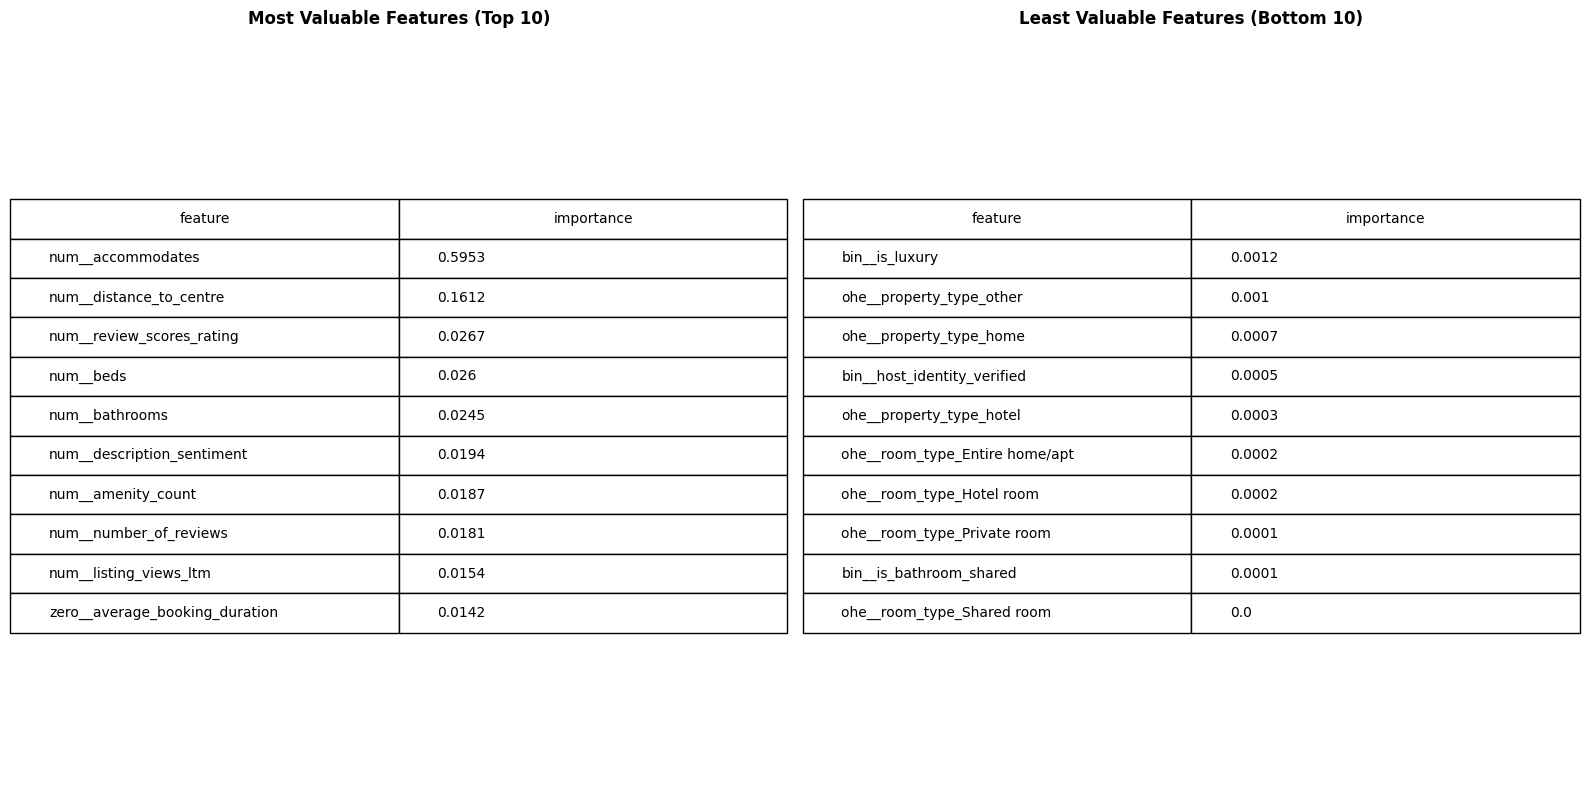

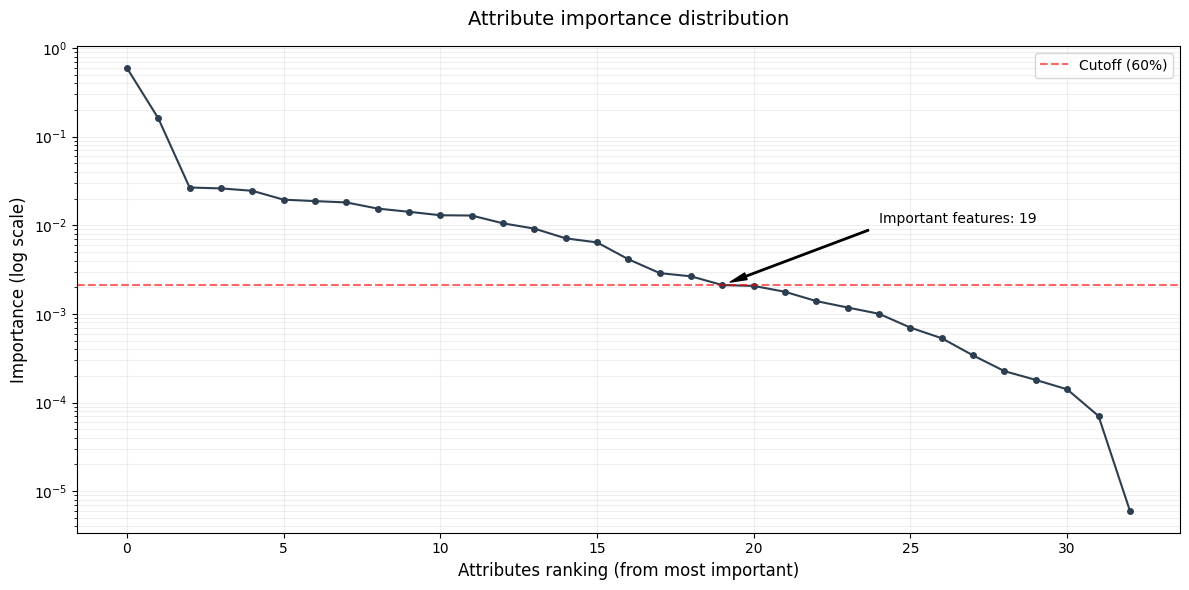

In [6]:
from src.visualizations.feature_importance import visualize_feature_importance_tables, plot_importance_distribution

visualize_feature_importance_tables(pipe_forest)
plot_importance_distribution(pipe_forest)

Jak pokazują powyższe statystyki dla modelu znaczących jest kilkanaście atrybutów, tylko one mają wartości *importance* powyżej niskiego i orientacyjnego progu decyzyjnego jakim jest 0.005. Wobec tego zostanie podjęta próba redukcji atrybutów, tak aby minimalizować skłonności modelu do przeuczenia.

Wartości atrybutów dyskretnych (zakodowane po przez *one-hot-encoding*) zostaną zagregowane - liczona jest suma składowych, która mówi jak bardzo dana cecha jest znacząca.

In [7]:
from src.selector import FeatureSelector

pipe_forest_full = Pipeline(
    [
        ("preprocessor", Preprocessor()),
        ("selector", FeatureSelector(
            RandomForestRegressor(n_jobs=1), percent=0.6, ohe_features=["room_type", "property_type"])),
        ("regressor", RandomForestRegressor(n_jobs=1))
    ]
)

pipe_forest_full.fit(X, y)
selected = pipe_forest_full.named_steps["selector"].selected_features_
selected

['num__accommodates',
 'num__distance_to_centre',
 'num__beds',
 'num__review_scores_rating',
 'num__bathrooms',
 'num__description_sentiment',
 'num__number_of_reviews',
 'num__amenity_count',
 'num__listing_views_ltm',
 'zero__average_booking_duration',
 'num__neighborhood_overview_sentiment',
 'num__bedrooms',
 'zero__average_lead_time',
 'num__conversion_rate_ltm',
 'num__maximum_nights',
 'ohe__property_type_condo',
 'ohe__property_type_home',
 'ohe__property_type_hotel',
 'ohe__property_type_other',
 'ohe__property_type_rental_unit']

In [8]:
cv_scores = cross_val_score(pipe_forest_full, X, y, cv=cv, scoring="neg_mean_absolute_error")
mae = -cv_scores

print(f"Mean CV MAE (random forest with cut attribues): {mae.mean():.2f} ± {mae.std():.2f}")

Mean CV MAE (random forest with cut attribues): 33.26 ± 2.09


Jak widać pomimo ograniczenia liczby atrybutów (zachowano 60% najbardziej znaczących) model radzi sobie tak samo dobrze z zadaniem przewidywania ceny, co oznacza, że odrzucone atrybuty były zbędne w procesie uczenia.

In [9]:
df = pd.DataFrame(
    {
        "feature": selected, 
        "importance": pipe_forest_full.named_steps["regressor"].feature_importances_
    }
)
df

,feature,importance
0,num__accommodates,0.593860
1,num__distance_to_centre,0.167056
2,num__beds,0.022069
3,num__review_scores_rating,0.026535
4,num__bathrooms,0.028337
5,num__description_sentiment,0.022263
6,num__number_of_reviews,0.020797
7,num__amenity_count,0.020319
8,num__listing_views_ltm,0.018738
9,zero__average_booking_duration,0.013339


#### Strojenie hiperparametrów modelu

Do strojenia hiperparametrów wybrano przeszukiwanie na siatce. Zdefiniowanych zostało kilka typowych zestawów atrybutów, które następnie łączone są w kolejne kombinacje, na których ewaluowana jest jakość modelu.

In [10]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "regressor__n_estimators": [50, 100, 150, 200, 300],
    "regressor__max_depth": [None, 10, 20, 30],
    "regressor__min_samples_split": [2, 5, 8, 10],
    "regressor__min_samples_leaf": [1, 2, 4],
}

grid_search = GridSearchCV(
    estimator=pipe_forest_full,
    param_grid=param_grid,
    cv=cv,  
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=0,
    refit=True,
)

grid_search.fit(X, y)

mse = -grid_search.best_score_
params = grid_search.best_params_

print(f"Best mean CV MAE (random forest) : {mse:.2f}")
print(f"Chosen parameters: {grid_search.best_params_}")

Best mean CV MAE (random forest) : 32.88
Chosen parameters: {'regressor__max_depth': 30, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100}


W tym przypadku las losowy wykazuje bardzo małą wrażliwość na strojenie hiperparametrów. Wynika to z faktu, że przewidywanie ceny jest stosunkowo prostym zadaniem - zależy ona liniowo od atrybutów niosących informację o tym, jak wiele osób jest w stanie pomieścić dane lokum. Mimo to, wybrane zostały najlepsze, być może wpłyną one pozytywnie na model. 

### Interpretacja wyników

#### Wykresy różnicy ceny danej i przewidzianej:
- Zielona belka - mediana dla klastra
- Środkowa sztabka - 50% środkowych wartości
- Knoty świec - skrajne predykcje

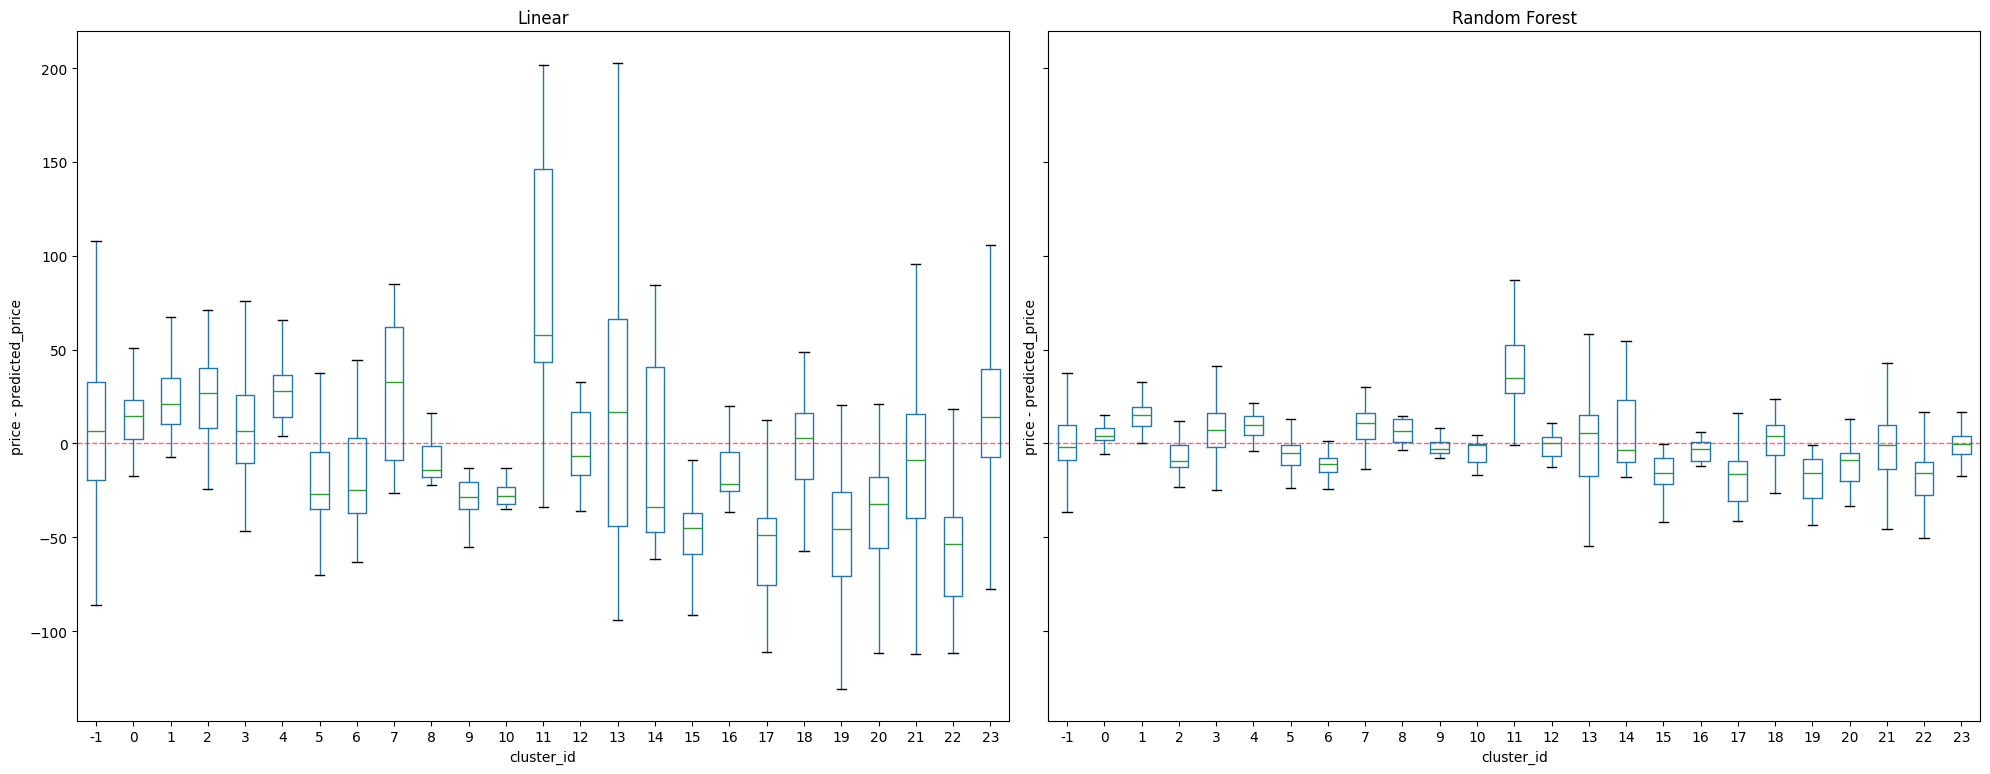

In [11]:
from src.visualizations.results import visualize_results_compare, visualize_map

pred_linear = pipe_linear.predict(X)
pred_rf = grid_search.best_estimator_.predict(X)

diff_linear = y -pred_linear
diff_rf = y - pred_rf 
visualize_results_compare(diff_linear, diff_rf, ids)

Interpretacja map
- Kolor zielony - zbyt mało ofert w regionie
- Kolor czerwony - zbyt dużo ofert w regionie

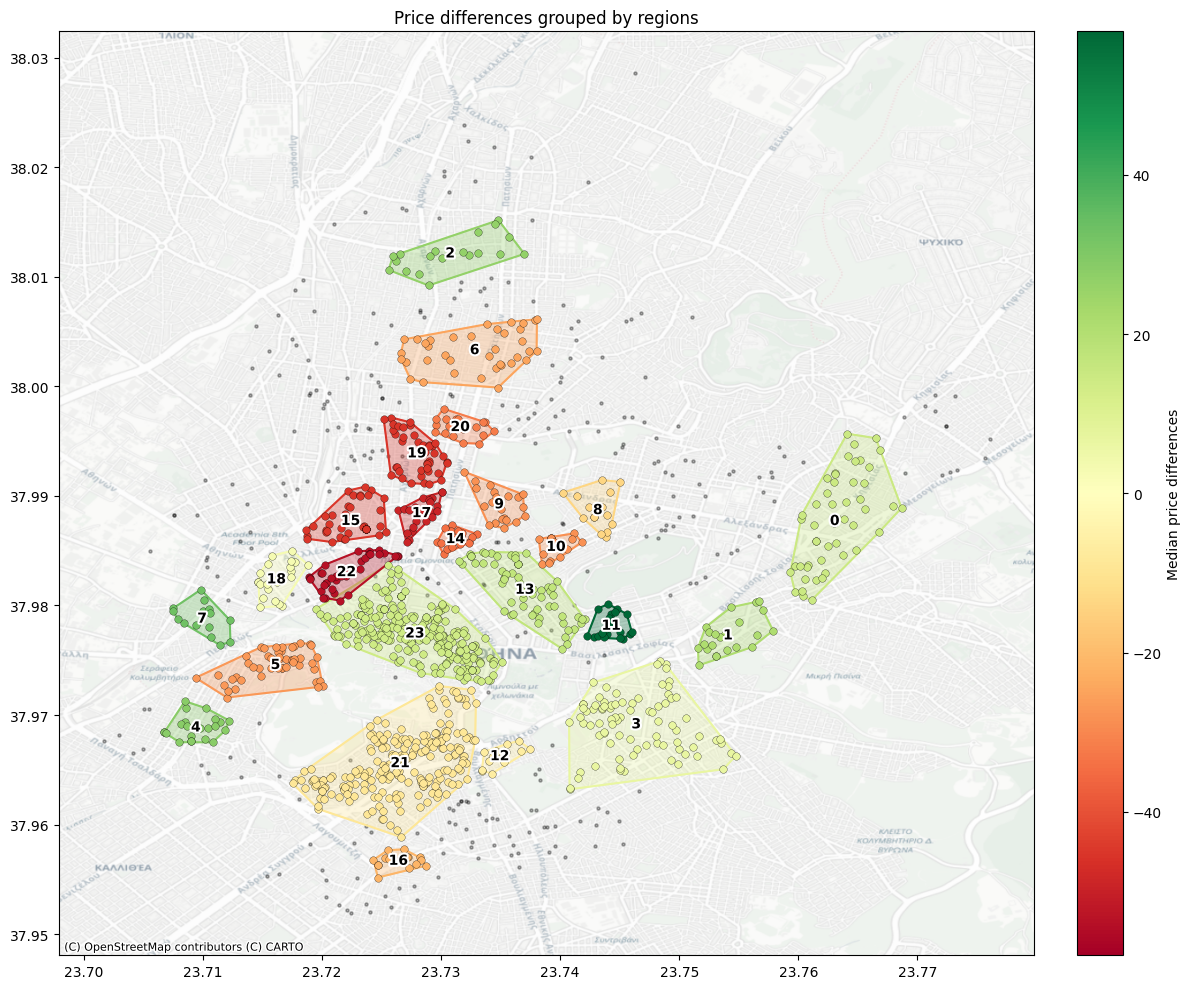

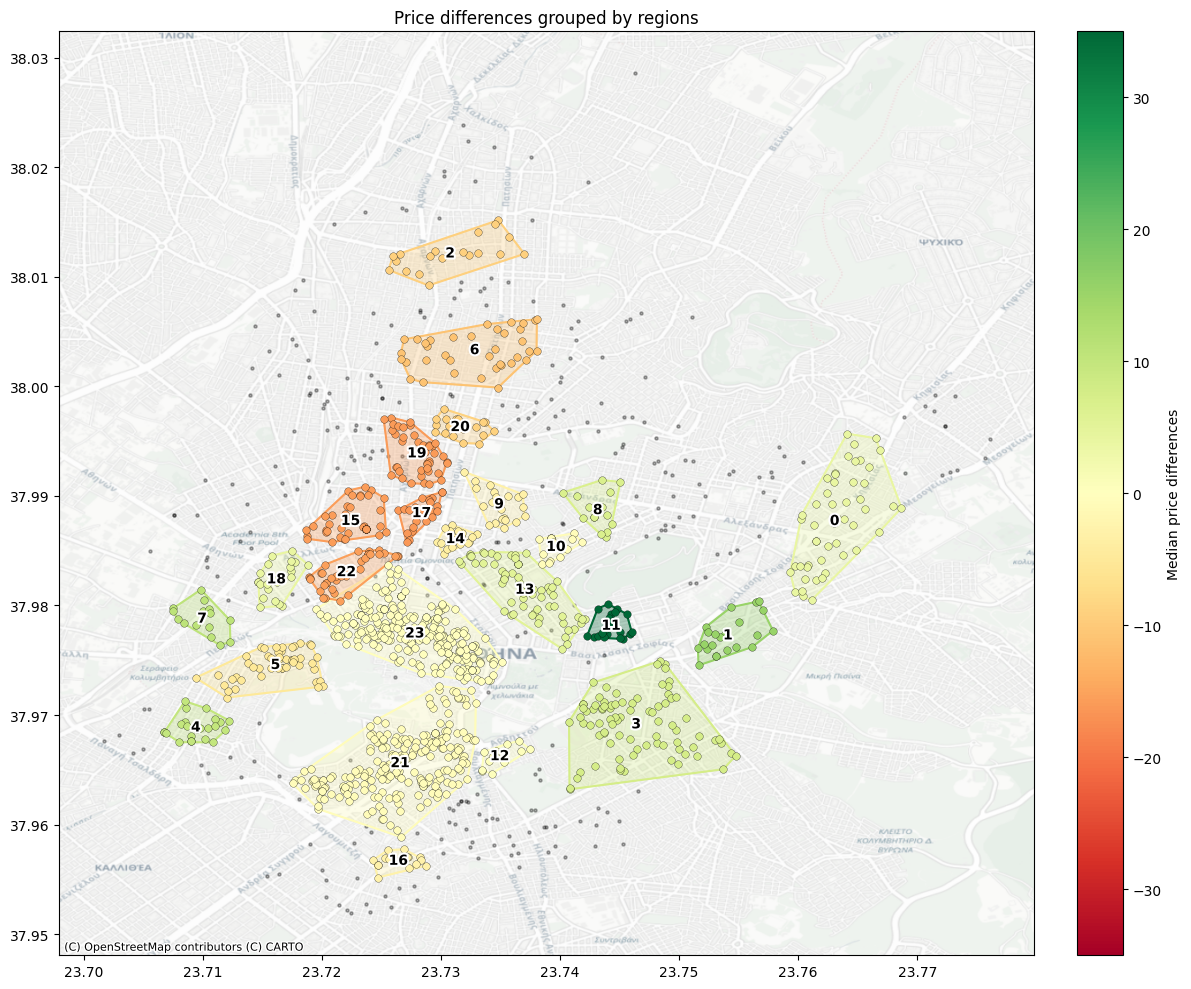

In [12]:
visualize_map(diff_linear, ids, listings)
visualize_map(diff_rf, ids, listings)

#### Rankingowanie - przedstawienie regionów z największą nadpodażą

In [13]:
df = pd.DataFrame({"price_spread": diff_rf, "cluster_id": ids})
stats = df.groupby("cluster_id")["price_spread"].median().sort_values()
stats

cluster_id
 17   -16.361339
 19   -15.886190
 15   -15.607321
 22   -15.499643
 6    -11.120774
 2     -9.236230
 20    -8.922143
 5     -5.044851
 14    -3.705317
 9     -3.144683
 16    -2.791190
-1     -1.625465
 10    -0.774425
 21    -0.708571
 23    -0.168462
 12     0.373929
 0      3.976766
 18     4.069911
 13     5.332560
 8      6.831786
 3      7.408241
 4     10.049821
 7     10.828983
 1     15.353224
 11    35.003571
Name: price_spread, dtype: float64

#### Zapisanie modelów do plików

In [14]:
import joblib
from pathlib import Path

models_dir = Path("../models")
models_dir.mkdir(exist_ok=True, parents=True)

joblib.dump(pipe_linear, models_dir / "linear_pipeline.joblib")
joblib.dump(pipe_forest_full, models_dir / "forest_pipeline.joblib")

['../models/forest_pipeline.joblib']

## Wnioski

1. **Błąd MAE** podczas uczenia modelu - różnica wartości między błędu między modelami jest niezbyt duża, może nie być statystycznie znacząca. Nie mówi jasno czy stosowanie lasu losowego jest konieczne.
2. **Mapy** - wyniki dla obydwu modeli są stosunkowo podobne. Obydwa modele znajdują te same regiony, w których presja cenowa odziałuje najmocniej. W przypadku regresji liniowej rozstrzały wartości są dużo większe, co świadczy o niedoskonałości modelu. 
3. **Wykresy statystyczne** - znacząco różnią się od siebie. Dla modelu regresji liniowej wyniki są bardziej skrajne, model nie jest w stanie wychwycić nieliniowych zależności, co prowadzi do bardzo dużych różnic predykcji w obrębie jednego klastra. Natomiast wyniki lasu losowego są bardziej stabilne, jest on w stanie dostrzec trudniejsze zależności, co przekłada się na mniej zaszumione wyniki.

Obserwacje wskazują, że w analizowanym problemie szukania regionów, w których liczba ofert jest zbyt duża **jest adekwatne** zastosowanie bardziej zaawansowanego modelu **lasu losowego**.